# Name : sandy adel latef beshay
# ID : 300389917

In [1]:
#pip install opencv-python
#pip install tensorflow

In [2]:
import os
import skimage.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import json

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#connect colab with drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
##extract file.zip
# zip_file_path = '/content/drive/MyDrive/a3_dataset.zip'
# destination_folder = '/content/drive/MyDrive'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(destination_folder)

# 2 Data Preparation

In [5]:
#define path and folders inside it
path="/content/drive/MyDrive/a3_dataset/img"
folders = [f for f in os.listdir(path)]
print("folders=", folders)

folders= ['Common_Chickweed', 'Cleavers', 'Maize', 'Shepherds_Purse']


In [6]:
#function to load image and resize it as (128,128,3)
def load_images(folder_path):
    images = []
    file_names = os.listdir(folder_path)

    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        image = skimage.io.imread(file_path)
        image = resize(image, (128, 128,3), anti_aliasing=True)
        images.append(image)

    return images

In [7]:
#function to display confusion matrix for (train,test,val)
def display_confusion_matrices(train_confusion, test_confusion, val_confusion,labels):
    disp_train = ConfusionMatrixDisplay(confusion_matrix=train_confusion, display_labels=labels)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_confusion, display_labels=labels)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=val_confusion, display_labels=labels)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.subplots_adjust(wspace=0.5)

    disp_train.plot(cmap=plt.cm.Blues, values_format="d", xticks_rotation=90, ax=axes[0])
    axes[0].set_title('Train Set')

    disp_test.plot(cmap=plt.cm.Blues, values_format="d", xticks_rotation=90, ax=axes[1])
    axes[1].set_title('Test Set')

    disp_val.plot(cmap=plt.cm.Blues, values_format="d", xticks_rotation=90, ax=axes[2])
    axes[2].set_title('Validation Set')

    plt.show()

In [8]:
#load the data and but it in dataframe
folders= ['Cleavers', 'Common_Chickweed', 'Maize', 'Shepherds_Purse']
data_df = pd.DataFrame(columns=['image', 'label'])

for folder in folders:
    images = load_images(os.path.join(path, folder))
    data = pd.DataFrame({'label': folder,'image': images})
    data_df = pd.concat([data,data_df], ignore_index=False)

In [9]:
data_df

,label,image
0,Shepherds_Purse,"[[[0.6780493642769607, 0.6893851485906863, 0.7..."
1,Shepherds_Purse,"[[[0.29819216260723036, 0.23939927045036766, 0..."
2,Shepherds_Purse,"[[[0.2784316119025735, 0.20000023935355393, 0...."
3,Shepherds_Purse,"[[[0.37698531805300245, 0.26220284256280635, 0..."
4,Shepherds_Purse,"[[[0.2775457964423367, 0.2248090137381856, 0.1..."
...,...,...
245,Cleavers,"[[[0.32726282246229793, 0.26600192898288955, 0..."
246,Cleavers,"[[[0.3486012615746481, 0.30639771500205787, 0...."
247,Cleavers,"[[[0.37871386925554673, 0.3233474287223591, 0...."
248,Cleavers,"[[[0.4993436728366475, 0.4637643370938717, 0.4..."


In [10]:
#load jason file data  and normlize (width,height)
with open('/content/drive/MyDrive/a3_dataset/bbox.json') as json_file:
    json_data = json.load(json_file)

width_array = []
height_array = []

for plant, entries in json_data.items():
    for entry_number, entry_data in entries.items():
        width = int(entry_data['width'])
        height = int(entry_data['height'])
        width_array.append(width)
        height_array.append(height)

image_width = np.max(width_array)
image_height = np.max(height_array)

normalized_width = width_array / image_width
normalized_height = height_array / image_height
normalized_tuple = tuple(zip(normalized_width, normalized_height))

data_df["width"]=normalized_width
data_df["height"]=normalized_height
data_df["tuple"]=normalized_tuple

In [11]:
data_df

,label,image,width,height,tuple
0,Shepherds_Purse,"[[[0.6780493642769607, 0.6893851485906863, 0.7...",0.226115,0.272024,"(0.22611464968152867, 0.2720238095238095)"
1,Shepherds_Purse,"[[[0.29819216260723036, 0.23939927045036766, 0...",0.046709,0.129167,"(0.04670912951167728, 0.12916666666666668)"
2,Shepherds_Purse,"[[[0.2784316119025735, 0.20000023935355393, 0....",0.021231,0.037500,"(0.021231422505307854, 0.0375)"
3,Shepherds_Purse,"[[[0.37698531805300245, 0.26220284256280635, 0...",0.032378,0.051786,"(0.03237791932059448, 0.05178571428571429)"
4,Shepherds_Purse,"[[[0.2775457964423367, 0.2248090137381856, 0.1...",0.125796,0.280952,"(0.12579617834394904, 0.28095238095238095)"
...,...,...,...,...,...
245,Cleavers,"[[[0.32726282246229793, 0.26600192898288955, 0...",0.214968,0.282143,"(0.21496815286624205, 0.28214285714285714)"
246,Cleavers,"[[[0.3486012615746481, 0.30639771500205787, 0....",0.027601,0.022619,"(0.027600849256900213, 0.02261904761904762)"
247,Cleavers,"[[[0.37871386925554673, 0.3233474287223591, 0....",0.033970,0.058929,"(0.03397027600849257, 0.05892857142857143)"
248,Cleavers,"[[[0.4993436728366475, 0.4637643370938717, 0.4...",0.071125,0.079762,"(0.07112526539278131, 0.07976190476190476)"


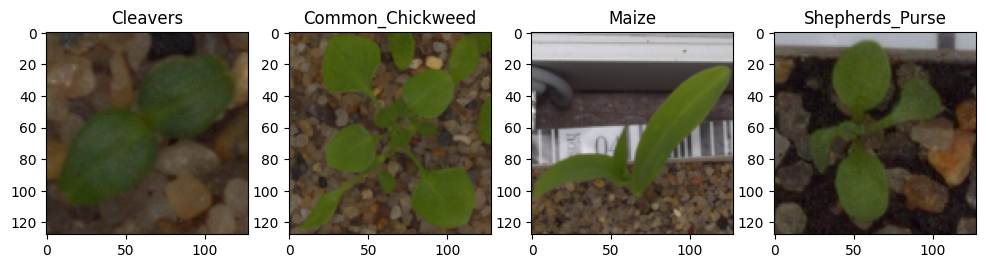

In [12]:
#plot first image in each class
plt.figure(figsize=(12, 3))

for i, folder in enumerate(folders):
    plt.subplot(1,4, i + 1)
    plt.imshow(data_df[data_df['label'] == folder]['image'].iloc[0])
    plt.title(folder)

plt.show()

In [13]:
#split data to (train,val,test) according to labels
train_set = pd.DataFrame(columns=['label', 'image'])
val_set = pd.DataFrame(columns=['label', 'image'])
test_set = pd.DataFrame(columns=['label', 'image'])

grouped = data_df.groupby('label')

for category, group_data in grouped:
    train_data, temp_data = train_test_split(group_data, train_size=0.6, random_state=42)
    val_data, test_data = train_test_split(temp_data, train_size=0.5, random_state=42)

    train_set = pd.concat([train_set, train_data])
    val_set = pd.concat([val_set, val_data])
    test_set = pd.concat([test_set, test_data])

train_set.reset_index(drop=True, inplace=True)
val_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

In [14]:
train_set

,label,image,width,height,tuple
0,Cleavers,"[[[0.47913012085771145, 0.4623700660329163, 0....",0.042463,0.073214,"(0.04246284501061571, 0.07321428571428572)"
1,Cleavers,"[[[0.5351252828289662, 0.3817649310105318, 0.2...",0.073779,0.113690,"(0.0737791932059448, 0.11369047619047619)"
2,Cleavers,"[[[0.410060398924082, 0.33176913386929946, 0.2...",0.030255,0.035119,"(0.030254777070063694, 0.03511904761904762)"
3,Cleavers,"[[[0.35762388939950984, 0.3070111443014706, 0....",0.036093,0.079762,"(0.036093418259023353, 0.07976190476190476)"
4,Cleavers,"[[[0.40905821688041294, 0.3454079119749525, 0....",0.263800,0.345833,"(0.2638004246284501, 0.3458333333333333)"
...,...,...,...,...,...
595,Shepherds_Purse,"[[[0.2469811366640759, 0.21342414393216685, 0....",0.016985,0.041071,"(0.016985138004246284, 0.04107142857142857)"
596,Shepherds_Purse,"[[[0.3932511871936275, 0.3160146675857843, 0.2...",0.082272,0.048214,"(0.08227176220806794, 0.048214285714285716)"
597,Shepherds_Purse,"[[[0.16862745098039217, 0.14509803921568626, 0...",0.036093,0.042857,"(0.036093418259023353, 0.04285714285714286)"
598,Shepherds_Purse,"[[[0.2824485694735594, 0.20527435567099522, 0....",0.052548,0.033929,"(0.052547770700636945, 0.033928571428571426)"


In [15]:
val_set

,label,image,width,height,tuple
0,Cleavers,"[[[0.356118834252451, 0.2774117264093137, 0.23...",0.049363,0.058929,"(0.04936305732484077, 0.05892857142857143)"
1,Cleavers,"[[[0.3068107290729488, 0.2959917451314308, 0.3...",0.057856,0.035714,"(0.05785562632696391, 0.03571428571428571)"
2,Cleavers,"[[[0.6160625382965687, 0.6356617647058824, 0.6...",0.043524,0.070833,"(0.0435244161358811, 0.07083333333333333)"
3,Cleavers,"[[[0.2505549879951271, 0.1972103916950639, 0.1...",0.117304,0.160714,"(0.1173036093418259, 0.16071428571428573)"
4,Cleavers,"[[[0.41457399477907037, 0.3547686633457221, 0....",0.101911,0.102976,"(0.10191082802547771, 0.10297619047619047)"
...,...,...,...,...,...
195,Shepherds_Purse,"[[[0.19627692009090866, 0.25847197958086504, 0...",0.222930,0.309524,"(0.2229299363057325, 0.30952380952380953)"
196,Shepherds_Purse,"[[[0.4102560500850931, 0.4048876122277242, 0.4...",0.126858,0.277976,"(0.12685774946921444, 0.2779761904761905)"
197,Shepherds_Purse,"[[[0.3205729166666666, 0.2612745098039216, 0.1...",0.065287,0.063690,"(0.06528662420382166, 0.06369047619047619)"
198,Shepherds_Purse,"[[[0.29163866230085783, 0.17853309780943627, 0...",0.106688,0.175000,"(0.10668789808917198, 0.175)"


In [16]:
test_set

,label,image,width,height,tuple
0,Cleavers,"[[[0.3892626676813086, 0.33232302972162653, 0....",0.458068,0.727381,"(0.458067940552017, 0.7273809523809524)"
1,Cleavers,"[[[0.3488395541321997, 0.2934627158969056, 0.2...",0.046709,0.020238,"(0.04670912951167728, 0.02023809523809524)"
2,Cleavers,"[[[0.4440716911764706, 0.39627757352941173, 0....",0.175159,0.151190,"(0.1751592356687898, 0.15119047619047618)"
3,Cleavers,"[[[0.327467657571974, 0.23743398702373875, 0.1...",0.084395,0.092262,"(0.08439490445859872, 0.09226190476190477)"
4,Cleavers,"[[[0.21191316685502082, 0.16456829853997124, 0...",0.026008,0.056548,"(0.026008492569002124, 0.05654761904761905)"
...,...,...,...,...,...
195,Shepherds_Purse,"[[[0.28345598840935154, 0.19119214126699796, 0...",0.169851,0.359524,"(0.16985138004246284, 0.3595238095238095)"
196,Shepherds_Purse,"[[[0.31169997387374937, 0.22764958096047622, 0...",0.152866,0.344643,"(0.15286624203821655, 0.34464285714285714)"
197,Shepherds_Purse,"[[[0.4123674775930652, 0.34440545819356855, 0....",0.145435,0.089881,"(0.1454352441613588, 0.08988095238095238)"
198,Shepherds_Purse,"[[[0.2648024018714406, 0.20436838214705622, 0....",0.058386,0.161905,"(0.058386411889596604, 0.1619047619047619)"


# 3.1 Classification Network

In [17]:
#specify x for (train,val,test) then convert them to np.array to match the model
x_train = train_set['image']
x_val = val_set['image']
x_test = test_set['image']

x_train = np.stack(x_train.values)
x_val = np.stack(x_val.values)
x_test = np.stack(x_test.values)

In [18]:
#specify y for (train,val,test) then convert them to categorical to match the model
y_train = train_set['label']
y_val = val_set['label']
y_test = test_set['label']

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

y_train = to_categorical(y_train_encoded, num_classes=4)
y_val = to_categorical(y_val_encoded, num_classes=4)
y_test = to_categorical(y_test_encoded, num_classes=4)

In [19]:
#create new version of a CNN network for the classification
base_model= VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

rmsprop = tf.keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer= rmsprop , metrics=['accuracy'])

print(model.summary())

history = model.fit(x_train, y_train, epochs=10, batch_size=25, verbose=1,validation_data=(x_val, y_val))

y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

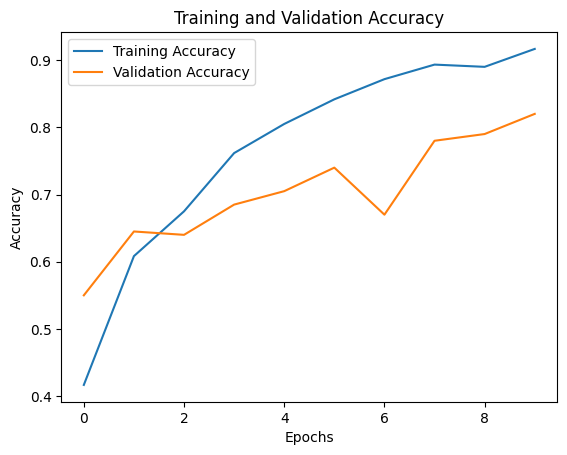

In [20]:
# Plot learning curves for training and validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Train Accuracy: 0.9716666666666667
Test Accuracy: 0.86
Validation Accuracy: 0.82
Train Confusion Matrix:
[[143   1   0   6]
 [  0 144   0   6]
 [  2   0 146   2]
 [  0   0   0 150]]
Test Confusion Matrix:
[[46  2  0  2]
 [ 0 41  0  9]
 [ 4  3 41  2]
 [ 3  3  0 44]]
Validation Confusion Matrix:
[[43  3  2  2]
 [ 2 38  1  9]
 [ 6  0 41  3]
 [ 2  4  2 42]]


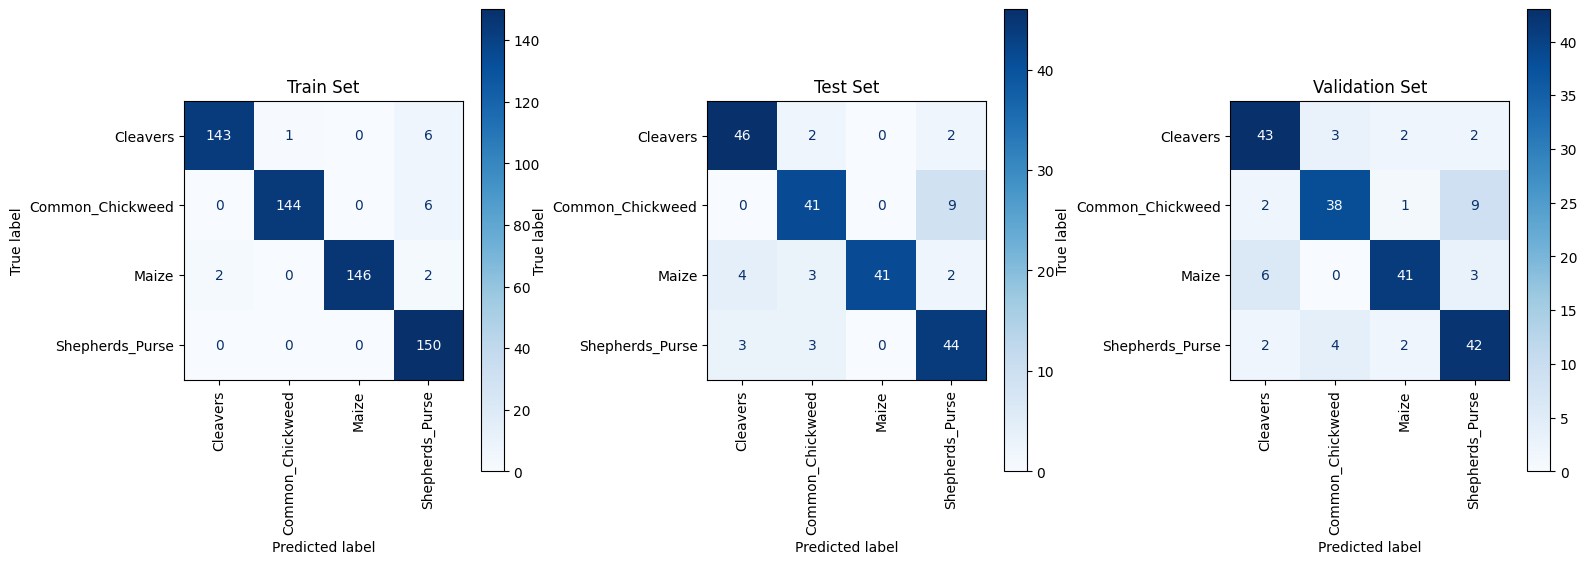

In [21]:
#compute accuracy and confusion matrix for (train,val,test)
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1))
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_test_pred, axis=1))
val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1))

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Validation Accuracy:", val_accuracy)

train_confusion = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1))
test_confusion = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_test_pred, axis=1))
val_confusion = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1))

print("Train Confusion Matrix:")
print(train_confusion)
print("Test Confusion Matrix:")
print(test_confusion)
print("Validation Confusion Matrix:")
print(val_confusion)

display_confusion_matrices(train_confusion, test_confusion, val_confusion, folders)

# 3.2 Regression Network

In [22]:
#specify new y for (train,val,test)
y_train_r = train_set[['width', 'height']]
y_val_r = val_set[['width', 'height']]
y_test_r = test_set[['width', 'height']]

In [23]:
#create new version of a CNN network for the Regression
base_model_r= VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model_r.layers:
    layer.trainable = False

x = base_model_r.layers[-1].output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model_r = Model(inputs=base_model_r.input, outputs=output)

rmsprop = tf.keras.optimizers.RMSprop(lr=0.0001)
model_r.compile(loss='mean_squared_error', optimizer= rmsprop )

print(model_r.summary())

history_r = model_r.fit(x_train, y_train_r, epochs=10, batch_size=25, validation_data=(x_val, y_val_r))

y_test_pred_r = model_r.predict(x_test)
y_train_pred_r = model_r.predict(x_train)
y_val_pred_r = model_r.predict(x_val)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

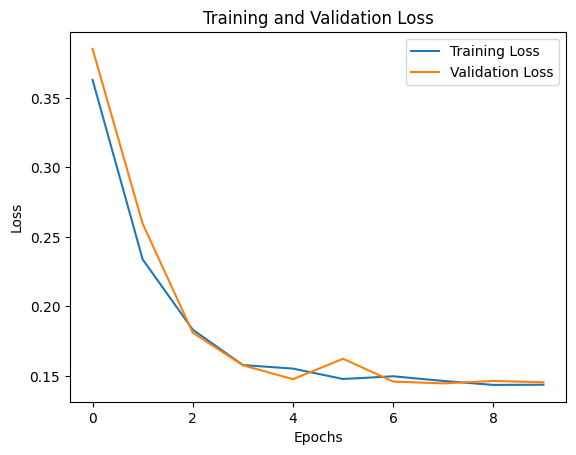

In [24]:
# Plot learning curves for training and validation
plt.plot(history_r.history['loss'], label='Training Loss')
plt.plot(history_r.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# compute MSE for (train,val,test)
mse_train = mean_squared_error(y_train_r, y_train_pred_r)
mse_val = mean_squared_error(y_val_r, y_val_pred_r)
mse_test = mean_squared_error(y_test_r, y_test_pred_r)

print("MSE for Training Data:", mse_train)
print("MSE for Validation Data:", mse_val)
print("MSE for Testing Data:", mse_test)

MSE for Training Data: 0.14397165003781867
MSE for Validation Data: 0.14546735938629649
MSE for Testing Data: 0.14622083121611384


# 4 Improving the Model

In [26]:
#create improved version of a CNN network for the classification
base_model_i= VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model_i.layers:
    layer.trainable = False

x = base_model_i.layers[-1].output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)  # Adding Batch Normalization
x = Dropout(0.5)(x)  # Adding Dropout with a rate of 0.5
x = Dense(64, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model_i = Model(inputs=base_model_i.input, outputs=output)

rmsprop = tf.keras.optimizers.RMSprop(lr=0.0001)
model_i.compile(loss='categorical_crossentropy', optimizer= rmsprop , metrics=['accuracy'])

print(model_i.summary())

history_i = model_i.fit(x_train, y_train, epochs=10, batch_size=25, verbose=1,validation_data=(x_val, y_val))

y_test_pred_i = model_i.predict(x_test)
y_train_pred_i = model_i.predict(x_train)
y_val_pred_i = model_i.predict(x_val)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

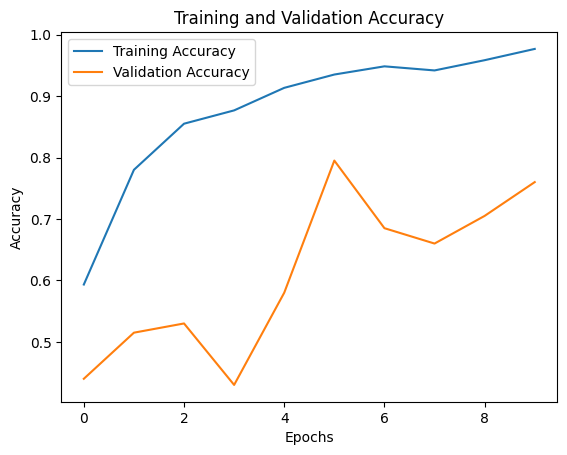

In [27]:
# Plot learning curves for training and validation
plt.plot(history_i.history['accuracy'], label='Training Accuracy')
plt.plot(history_i.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Train Accuracy: 0.9733333333333334
Test Accuracy: 0.81
Validation Accuracy: 0.76
Train Confusion Matrix:
[[141   0   0   9]
 [  0 143   0   7]
 [  0   0 150   0]
 [  0   0   0 150]]
Test Confusion Matrix:
[[38  0  2 10]
 [ 0 33  1 16]
 [ 2  1 45  2]
 [ 0  0  4 46]]
Validation Confusion Matrix:
[[31  2  6 11]
 [ 0 30  2 18]
 [ 3  0 45  2]
 [ 1  2  1 46]]


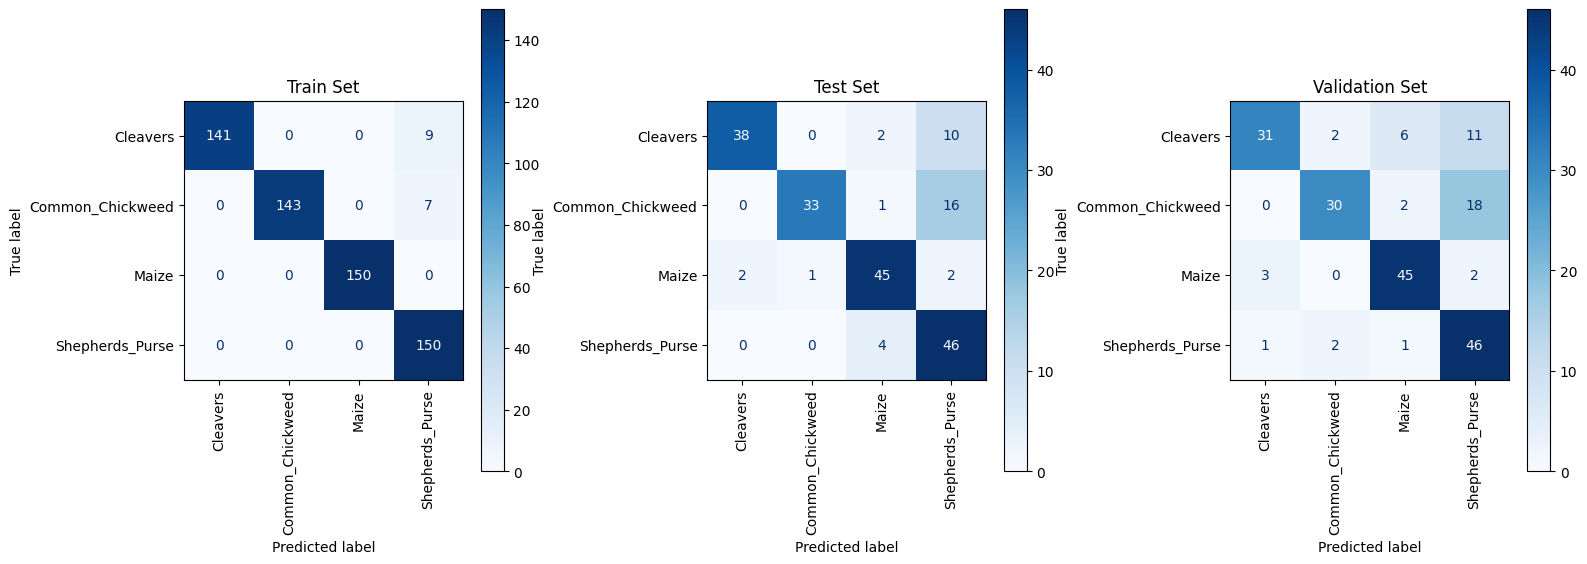

In [28]:
#compute accuracy and confusion matrix for (train,val,test)
train_accuracy_i = accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred_i, axis=1))
test_accuracy_i = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_test_pred_i, axis=1))
val_accuracy_i = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred_i, axis=1))

print("Train Accuracy:", train_accuracy_i)
print("Test Accuracy:", test_accuracy_i)
print("Validation Accuracy:", val_accuracy_i)

train_confusion_i = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(y_train_pred_i, axis=1))
test_confusion_i = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_test_pred_i, axis=1))
val_confusion_i = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_val_pred_i, axis=1))

print("Train Confusion Matrix:")
print(train_confusion_i)
print("Test Confusion Matrix:")
print(test_confusion_i)
print("Validation Confusion Matrix:")
print(val_confusion_i)

display_confusion_matrices(train_confusion_i, test_confusion_i, val_confusion_i, folders)

# 5 Discussion

**Question 3.1 (Classification):**
- There is a minor degree of overfitting observed as the training accuracy is slightly higher than the test and validation accuracies.
- Overfitting is not severe, as the differences in accuracy are relatively small.

**Question 3.2 (Regression - MSE):**
- Overfitting is not a significant concern since the difference between training and validation/testing MSE is small.

**Question 4 (After Applying Regularization):**
- Regularization has been applied, resulting in a slight increase in training accuracy.
- Test and validation accuracies have decreased, indicating that the model may generalize better to unseen data but fit the training data less closely.

In summary, regularization has helped reduce overfitting, but it's important to consider the trade-off between training accuracy and generalization. The model now appears to strike a better balance between fitting the training data and generalizing to new data. Further fine-tuning of regularization parameters may be beneficial to optimize this balance.